# Facial Emotion Recognition Using Machine Learning Methods

In [1]:
import os

from platform import python_version
import warnings
import time
import datetime as dt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import multiprocessing as mp
import shutil
from tqdm import tqdm
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.densenet import DenseNet121, preprocess_input, decode_predictions
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.utils import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.initializers import *
from tensorflow.keras import regularizers

import pandas as pd
import numpy as np
import seaborn as sns
from plotly.subplots import make_subplots
import plotly.graph_objects as go

from PIL import Image
import xml.etree.ElementTree as ET
import psutil
import random

warnings.filterwarnings("ignore")
%matplotlib inline

2025-04-16 06:55:45.742682: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744786545.984109      72 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744786546.058910      72 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Data Preprocessing

In [2]:
DATADIR = r'/kaggle/input/ck-dataset'
CATEGORIES = os.listdir(DATADIR)
CATEGORIES

['surprise', 'fear', 'sadness', 'disgust', 'contempt', 'happy', 'anger']

In [3]:
def load_data():
    data = []
    for category in CATEGORIES:
        path = os.path.join(DATADIR, category)
        class_num = CATEGORIES.index(category)
        
        for img in tqdm(os.listdir(path)):
            img_array = cv2.imread(os.path.join(path, img), 0)
            data.append([img_array, class_num])
    return data

data = load_data()

100%|██████████| 135/135 [00:00<00:00, 186.82it/s]


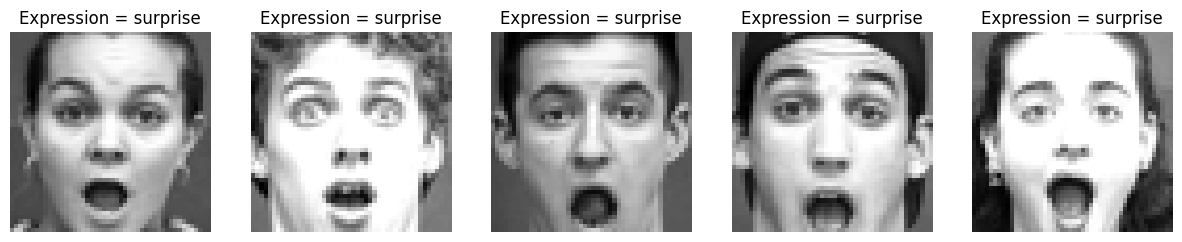

In [4]:
samples = data[0:5]

fig, axes = plt.subplots(1, len(samples), figsize=(15,5))

for i, sample in enumerate(samples):
    img = sample[0]      
    label = sample[1]   
    axes[i].set_title("Expression = " + str(CATEGORIES[label]))
    axes[i].imshow(img, cmap='gray')
    axes[i].axis('off')

plt.show()

In [5]:
import os
import cv2
import numpy as np
import random
from tqdm import tqdm
from skimage.feature import hog
import dlib
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report


DATADIR = r'/kaggle/input/ck-dataset'
CATEGORIES = os.listdir(DATADIR)
IMG_SIZE = 64  

# -------------------------------
# Thiết lập face detector và predictor (cho face alignment)
# -------------------------------
predictor_path = "/kaggle/input/shape-predictor-68-face-landmarks/shape_predictor_68_face_landmarks.dat"
if os.path.exists(predictor_path):
    detector = dlib.get_frontal_face_detector()
    predictor = dlib.shape_predictor(predictor_path)
    use_alignment = True
    print("Face alignment sẽ được sử dụng.")
else:
    print("Warning: Không tìm thấy file shape_predictor_68_face_landmarks.dat. Bỏ qua face alignment.")
    use_alignment = False

def enhance_image(img):
    """
    Histogram equalization là một kỹ thuật xử lý ảnh nhằm cải thiện độ tương phản bằng cách phân bố lại 
    các giá trị pixel sao cho histogram của ảnh được trải đều hơn. Kỹ thuật này giúp làm nổi bật các chi tiết 
    quan trọng trong ảnh, đặc biệt hữu ích khi ảnh có các vùng quá tối hoặc quá sáng.

    Steps:
        1. Nhận ảnh đầu vào dạng grayscale dưới dạng mảng NumPy.
        2. Sử dụng cv2.equalizeHist để áp dụng histogram equalization.
        3. Trả về ảnh sau khi được tăng cường.

    Parameters:
        img (numpy.ndarray): Ảnh đầu vào ở dạng grayscale (mảng 2 chiều).

    Returns:
        numpy.ndarray: Ảnh đã được xử lý, với độ tương phản được cải thiện.
    """
    return cv2.equalizeHist(img)

def align_face(img):
    """
    Thực hiện canh chỉnh khuôn mặt trong ảnh bằng cách sử dụng thư viện dlib.

    Quy trình:
        1. Phát hiện khuôn mặt trong ảnh sử dụng detector của dlib.
        2. Nếu có khuôn mặt, dự đoán 68 điểm landmark của khuôn mặt đó.
        3. Tính vị trí trung bình của mắt trái và mắt phải từ các landmark tương ứng.
        4. Tính góc giữa đường nối hai mắt và xoay ảnh sao cho đường nối này nằm ngang.
        5. Trả về ảnh đã được xoay (canh chỉnh).
        6. Nếu không phát hiện được khuôn mặt, trả về ảnh gốc.

    Parameters:
        img (numpy.ndarray): Ảnh đầu vào dạng grayscale.

    Returns:
        numpy.ndarray: Ảnh đã được canh chỉnh (nếu khuôn mặt được phát hiện) hoặc ảnh gốc nếu không thể canh chỉnh.
    """
    rects = detector(img, 1)
    if len(rects) == 0:
        return img
    rect = rects[0]
    shape = predictor(img, rect)
    landmarks = np.array([[p.x, p.y] for p in shape.parts()])
    left_eye_pts = landmarks[36:42]
    right_eye_pts = landmarks[42:48]
    left_eye_center = left_eye_pts.mean(axis=0).astype(int)
    right_eye_center = right_eye_pts.mean(axis=0).astype(int)
    eyes_center = (int((left_eye_center[0] + right_eye_center[0]) / 2),
                   int((left_eye_center[1] + right_eye_center[1]) / 2))
    dY = right_eye_center[1] - left_eye_center[1]
    dX = right_eye_center[0] - left_eye_center[0]
    angle = np.degrees(np.arctan2(dY, dX))
    M = cv2.getRotationMatrix2D(eyes_center, angle, 1)
    aligned_img = cv2.warpAffine(img, M, (img.shape[1], img.shape[0]), flags=cv2.INTER_CUBIC)
    return aligned_img

def preprocess_image(img_path):
    """
    Thực hiện tiền xử lý cho ảnh dựa trên đường dẫn đến ảnh.

    Quy trình tiền xử lý bao gồm:
        1. Đọc ảnh ở dạng grayscale.
        2. Tăng cường ảnh bằng histogram equalization.
        3. Nếu được thiết lập sử dụng face alignment, canh chỉnh khuôn mặt.
        4. Resize ảnh về kích thước chuẩn (ví dụ: 64x64).

    Parameters:
        img_path (str): Đường dẫn đến ảnh.

    Returns:
        numpy.ndarray: Ảnh đã được tiền xử lý.
                        Nếu không đọc được ảnh, trả về None.
    """
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        return None
    enhanced = enhance_image(img)
    if use_alignment:
        aligned = align_face(enhanced)
    else:
        aligned = enhanced
    resized = cv2.resize(aligned, (IMG_SIZE, IMG_SIZE))
    return resized

def load_data():
    data = []
    labels = []
    for cat in CATEGORIES:
        path = os.path.join(DATADIR, cat)
        label = CATEGORIES.index(cat)
        for file in tqdm(os.listdir(path), desc=f"Processing {cat}"):
            img_path = os.path.join(path, file)
            processed = preprocess_image(img_path)
            if processed is not None:
                data.append(processed)
                labels.append(label)
    return np.array(data), np.array(labels)

print("Loading và tiền xử lý dữ liệu...")
images, labels = load_data()

Face alignment sẽ được sử dụng.
Loading và tiền xử lý dữ liệu...


Processing anger: 100%|██████████| 135/135 [00:00<00:00, 177.66it/s]


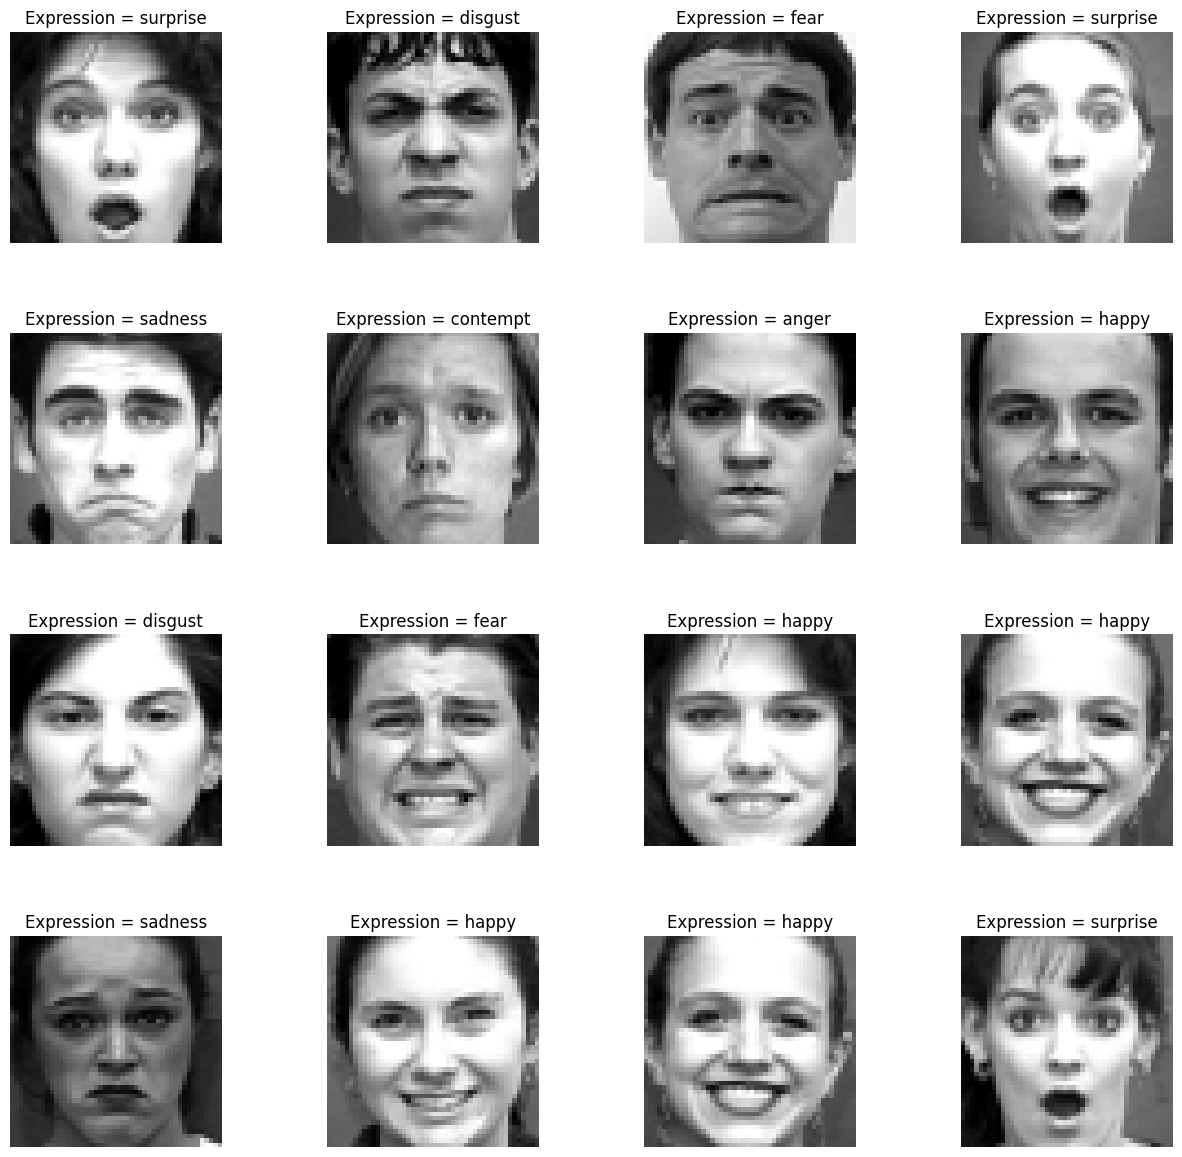

In [6]:
import matplotlib.pyplot as plt
L = 4
W = 4
fig, axes = plt.subplots(L, W, figsize = (15,15))
axes = axes.ravel()

for i in range(0, L*W):
    sample = random.choice(data)
    axes[i].set_title("Expression = "+str(CATEGORIES[sample[1]]))
    axes[i].imshow(sample[0], cmap='gray')
    axes[i].axis('off')
plt.subplots_adjust(wspace=0.5)

## KNN

## KNN Code Hàm

In [7]:
import os
import cv2
import numpy as np
from tqdm import tqdm
from skimage.feature import hog
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt

def extract_hog_features(image):
    """
    Trích xuất đặc trưng HOG từ ảnh grayscale.
    
    Parameters:
        image (np.ndarray): Ảnh đầu vào dạng grayscale.
        
    Returns:
        np.ndarray: Vector đặc trưng HOG.
    """
    features = hog(image,
                   orientations=9,
                   pixels_per_cell=(8, 8),
                   cells_per_block=(2, 2),
                   block_norm='L2-Hys',
                   visualize=False,
                   transform_sqrt=True)
    return features

def extract_dct_features(image, keep_coeffs=8):
    """
    Trích xuất đặc trưng DCT từ ảnh.
    
    Quy trình:
      - Chuyển ảnh sang float32 và chuẩn hóa giá trị pixel về [0, 1].
      - Tính DCT của ảnh bằng hàm cv2.dct.
      - Lấy block góc trên bên trái có kích thước keep_coeffs x keep_coeffs.
      - Làm phẳng block thành vector đặc trưng.
    
    Parameters:
        image (np.ndarray): Ảnh đầu vào dạng grayscale.
        keep_coeffs (int): Số coefficient cần giữ trên mỗi chiều (mặc định 8, tức 8x8 = 64 đặc trưng).
        
    Returns:
        np.ndarray: Vector đặc trưng DCT.
    """
    img_float = np.float32(image) / 255.0
    dct = cv2.dct(img_float)
    dct_block = dct[:keep_coeffs, :keep_coeffs]
    return dct_block.flatten()

def extract_combined_features(images):
    """
    Với mỗi ảnh, trích xuất đặc trưng HOG và DCT sau đó nối (concatenate) chúng lại thành vector đặc trưng chung.
    
    Parameters:
        images (np.ndarray): Mảng các ảnh.
    
    Returns:
        np.ndarray: Ma trận đặc trưng với kích thước (số mẫu, số chiều HOG + 64).
    """
    hog_feats = [extract_hog_features(img) for img in tqdm(images, desc="Extracting HOG features")]
    dct_feats = [extract_dct_features(img, keep_coeffs=8) for img in tqdm(images, desc="Extracting DCT features")]
    hog_feats = np.array(hog_feats)
    dct_feats = np.array(dct_feats)
    combined = np.concatenate((hog_feats, dct_feats), axis=1)
    return combined

combined_features = extract_combined_features(images)
print("Số chiều ban đầu của vector đặc trưng kết hợp:", combined_features.shape[1])

Extracting DCT features: 100%|██████████| 981/981 [00:00<00:00, 20269.33it/s]


Số chiều ban đầu của vector đặc trưng kết hợp: 1828


Số thành phần được chọn: 208
Tỷ lệ phương sai giải thích: 0.9000637563180738


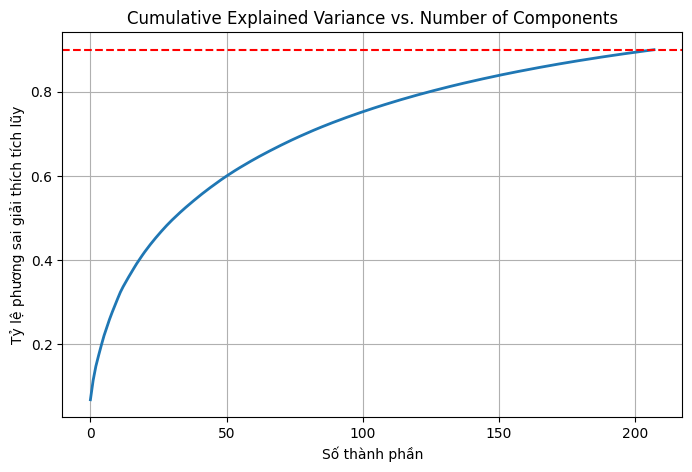

Best parameters cho KNN: {'n_neighbors': 1, 'weights': 'uniform'}
Best cross-validation accuracy: 0.9196553976808755
KNN Accuracy : 0.9847715736040609
Classification Report:
              precision    recall  f1-score   support

    surprise       1.00      1.00      1.00        42
        fear       1.00      1.00      1.00        21
     sadness       1.00      1.00      1.00        18
     disgust       1.00      0.92      0.96        37
    contempt       0.88      1.00      0.93        14
       happy       1.00      1.00      1.00        42
       anger       0.96      1.00      0.98        23

    accuracy                           0.98       197
   macro avg       0.98      0.99      0.98       197
weighted avg       0.99      0.98      0.98       197



In [8]:
def reduce_dimensionality(features, variance_threshold=0.95):
    """
    Chuẩn hóa và giảm chiều vector đặc trưng bằng StandardScaler và PCA, 
    tự động giữ lại đủ số thành phần để tổng tỷ lệ phương sai giải thích đạt ngưỡng nhất định.
    
    Parameters:
        features (np.ndarray): Ma trận đặc trưng ban đầu.
        variance_threshold (float): Ngưỡng tỷ lệ phương sai giải thích (ví dụ 0.95 nghĩa là 95%).
        
    Returns:
        features_pca (np.ndarray): Ma trận đặc trưng sau PCA.
        pca (PCA object): Mô hình PCA đã fit.
    """
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(features)
    
    # Sử dụng PCA để tự động chọn số thành phần sao cho đạt ngưỡng explained variance
    pca = PCA(n_components=variance_threshold)
    features_pca = pca.fit_transform(scaled_features)
    
    print("Số thành phần được chọn:", pca.n_components_)
    print("Tỷ lệ phương sai giải thích:", np.sum(pca.explained_variance_ratio_))

    import matplotlib.pyplot as plt
    cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
    plt.figure(figsize=(8, 5))
    plt.plot(cumulative_variance, linewidth=2)
    plt.xlabel("Số thành phần")
    plt.ylabel("Tỷ lệ phương sai giải thích tích lũy")
    plt.title("Cumulative Explained Variance vs. Number of Components")
    plt.grid(True)
    plt.axhline(y=variance_threshold, color='r', linestyle='--')
    plt.show()
    return features_pca, pca, scaler

features_pca, pca_model, scaler = reduce_dimensionality(combined_features, variance_threshold=0.9)
# -------------------------------
# Chia dữ liệu thành tập huấn luyện và test
# -------------------------------
X_train, X_test, y_train, y_test = train_test_split(features_pca, labels, test_size=0.2, random_state=42)

# -------------------------------
# Tối ưu hóa siêu tham số cho KNN bằng GridSearchCV
# -------------------------------
def grid_search_knn(X_train, y_train):
    """
    Sử dụng GridSearchCV để tìm các siêu tham số tối ưu cho KNN.
    
    Parameters:
        X_train (np.ndarray): Ma trận đặc trưng huấn luyện.
        y_train (np.ndarray): Nhãn huấn luyện.
        
    Returns:
        best_knn (estimator): Mô hình KNN với siêu tham số tối ưu.
        grid (GridSearchCV object): Đối tượng GridSearchCV đã được fit.
    """
    param_grid = {
        'n_neighbors': [1, 3, 5, 7, 9],
        'weights': ['uniform', 'distance']
    }
    knn = KNeighborsClassifier()
    grid = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    grid.fit(X_train, y_train)
    
    print("Best parameters cho KNN:", grid.best_params_)
    print("Best cross-validation accuracy:", grid.best_score_)
    
    best_knn = grid.best_estimator_
    return best_knn, grid

best_knn, grid = grid_search_knn(X_train, y_train)

# -------------------------------
# Đánh giá mô hình KNN trên tập test
# -------------------------------
y_pred = best_knn.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print("KNN Accuracy :", acc)
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=CATEGORIES))


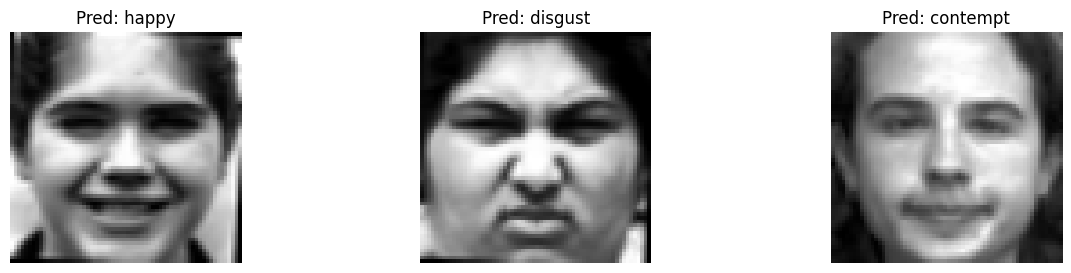

In [9]:
def predict_image(img_path, knn_model, scaler, pca):
    """
    Hàm này nhận đường dẫn đến ảnh, thực hiện tiền xử lý và trích xuất đặc trưng (HOG + DCT),
    sau đó chuẩn hóa và giảm chiều bằng scaler và PCA đã huấn luyện.
    Cuối cùng, mô hình KNN được dùng để dự đoán nhãn của ảnh.

    Parameters:
        img_path (str): Đường dẫn đến ảnh.
        knn_model (estimator): Mô hình KNN đã được huấn luyện.
        scaler (StandardScaler): Đối tượng scaler đã fit trên dữ liệu huấn luyện.
        pca (PCA): Mô hình PCA đã được fit trên dữ liệu huấn luyện.

    Returns:
        tuple: (predicted_label, processed_img)
    """
    processed_img = preprocess_image(img_path)  # Hàm preprocess_image phải được định nghĩa sẵn trong pipeline của bạn
    if processed_img is None:
        raise ValueError("Không đọc được ảnh từ đường dẫn: " + img_path)
    
    hog_feat = extract_hog_features(processed_img)
    dct_feat = extract_dct_features(processed_img, keep_coeffs=8)  # 8x8 = 64 đặc trưng
    combined = np.concatenate((hog_feat, dct_feat))
    
    # Chuẩn hóa vector đặc trưng theo scaler đã học (với input là một mảng 2 chiều)
    combined_scaled = scaler.transform([combined])
    # Giảm chiều vector đặc trưng sử dụng PCA đã học
    combined_pca = pca.transform(combined_scaled)
    predicted = knn_model.predict(combined_pca)
    return predicted[0], processed_img

# Danh sách đường dẫn ảnh cần dự đoán ví dụ:
test_image_paths = [
    '/kaggle/input/ck-dataset/happy/S011_006_00000011.png',
    '/kaggle/input/ck-dataset/disgust/S005_001_00000009.png',
    '/kaggle/input/ck-dataset/contempt/S151_002_00000029.png'
]

fig, axes = plt.subplots(1, len(test_image_paths), figsize=(15, 3))
for ax, img_path in zip(axes, test_image_paths):
    pred_label, img = predict_image(img_path, best_knn, scaler, pca_model)
    ax.imshow(img, cmap='gray')
    ax.set_title("Pred: " + CATEGORIES[pred_label])
    ax.axis('off')

plt.show()

## SVM

## SVM Code Hàm

Số thành phần được chọn: 208
Tỷ lệ phương sai giải thích: 0.9000637563180738


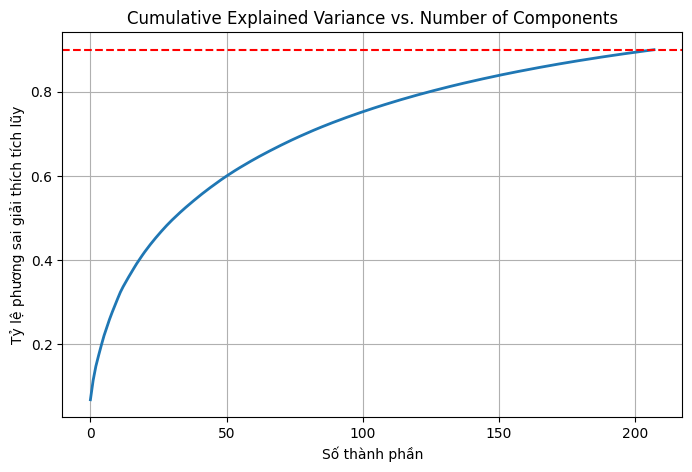

Best parameters: {'C': 0.01, 'gamma': 'scale', 'kernel': 'linear'}
Best cross-validation accuracy: 0.9744977951984322
SVM Accuracy: 1.0
              precision    recall  f1-score   support

    surprise       1.00      1.00      1.00        42
        fear       1.00      1.00      1.00        21
     sadness       1.00      1.00      1.00        18
     disgust       1.00      1.00      1.00        37
    contempt       1.00      1.00      1.00        14
       happy       1.00      1.00      1.00        42
       anger       1.00      1.00      1.00        23

    accuracy                           1.00       197
   macro avg       1.00      1.00      1.00       197
weighted avg       1.00      1.00      1.00       197



In [10]:
from skimage.feature import hog
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report


# -------------------------------
# Chuẩn hóa và giảm chiều với PCA
# -------------------------------
def reduce_dimensionality(features, variance_threshold=0.95):
    """
    Chuẩn hóa và giảm chiều vector đặc trưng bằng StandardScaler và PCA, 
    tự động giữ lại đủ số thành phần để tổng tỷ lệ phương sai giải thích đạt ngưỡng nhất định.
    
    Parameters:
        features (np.ndarray): Ma trận đặc trưng ban đầu.
        variance_threshold (float): Ngưỡng tỷ lệ phương sai giải thích (ví dụ 0.95 nghĩa là 95%).
        
    Returns:
        features_pca (np.ndarray): Ma trận đặc trưng sau PCA.
        pca (PCA object): Mô hình PCA đã fit.
    """
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(features)
    
    # Sử dụng PCA để tự động chọn số thành phần sao cho đạt ngưỡng explained variance
    pca = PCA(n_components=variance_threshold)
    features_pca = pca.fit_transform(scaled_features)
    
    print("Số thành phần được chọn:", pca.n_components_)
    print("Tỷ lệ phương sai giải thích:", np.sum(pca.explained_variance_ratio_))

    import matplotlib.pyplot as plt
    cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
    plt.figure(figsize=(8, 5))
    plt.plot(cumulative_variance, linewidth=2)
    plt.xlabel("Số thành phần")
    plt.ylabel("Tỷ lệ phương sai giải thích tích lũy")
    plt.title("Cumulative Explained Variance vs. Number of Components")
    plt.grid(True)
    plt.axhline(y=variance_threshold, color='r', linestyle='--')
    plt.show()
    return features_pca, pca, scaler


features_pca, pca_model, scaler = reduce_dimensionality(combined_features, variance_threshold=0.9)
X_train, X_test, y_train, y_test = train_test_split(features_pca, labels, test_size=0.2, random_state=42)

def grid_search_svm(X_train, y_train):
    """
    Sử dụng GridSearchCV để tìm các siêu tham số tối ưu cho SVM.
    
    Parameters:
        X_train (np.ndarray): Ma trận đặc trưng huấn luyện.
        y_train (np.ndarray): Nhãn huấn luyện.
    
    Returns:
        best_svm (estimator): Mô hình SVM với siêu tham số tối ưu.
        grid (GridSearchCV object): Đối tượng grid search đã được fit.
    """
    param_grid = {
        'C': [0.01, 0.1, 1, 10, 100],
        'kernel': ['linear', 'rbf'],
        'gamma': ['scale', 'auto']  # gamma chỉ áp dụng đối với kernel 'rbf'
    }
    
    svm = SVC(random_state=42)
    grid = GridSearchCV(svm, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    grid.fit(X_train, y_train)
    
    print("Best parameters:", grid.best_params_)
    print("Best cross-validation accuracy:", grid.best_score_)
    best_svm = grid.best_estimator_
    return best_svm, grid

best_svm, grid = grid_search_svm(X_train, y_train)

y_pred = best_svm.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print("SVM Accuracy:", acc)
print(classification_report(y_test, y_pred, target_names=CATEGORIES))


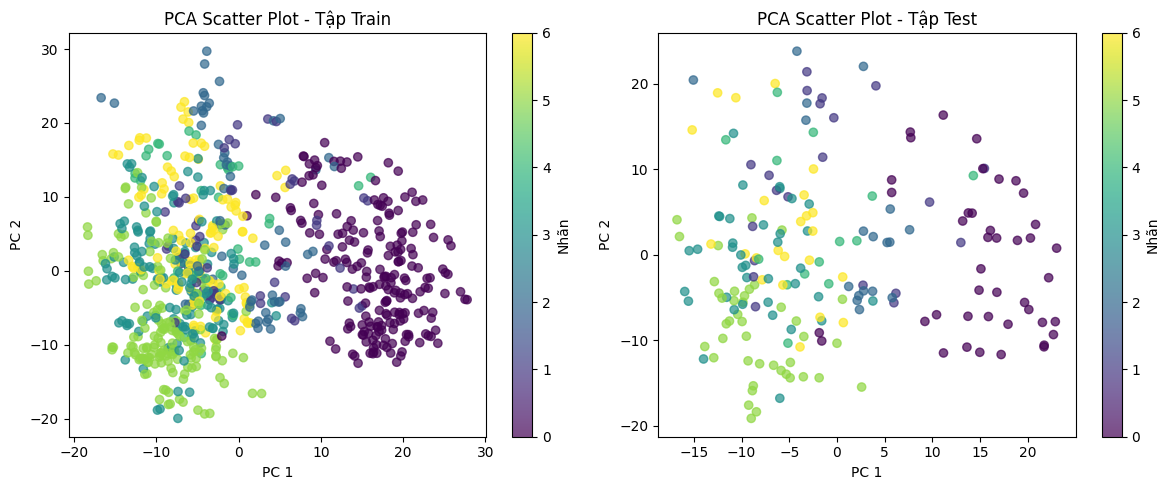

In [11]:
import matplotlib.pyplot as plt

# Giả sử X_train và X_test là dữ liệu sau PCA
plt.figure(figsize=(12, 5))

# Biểu đồ scatter cho tập train
plt.subplot(1, 2, 1)
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='viridis', alpha=0.7)
plt.title('PCA Scatter Plot - Tập Train')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.colorbar(label='Nhãn')

# Biểu đồ scatter cho tập test
plt.subplot(1, 2, 2)
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap='viridis', alpha=0.7)
plt.title('PCA Scatter Plot - Tập Test')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.colorbar(label='Nhãn')

plt.tight_layout()
plt.show()


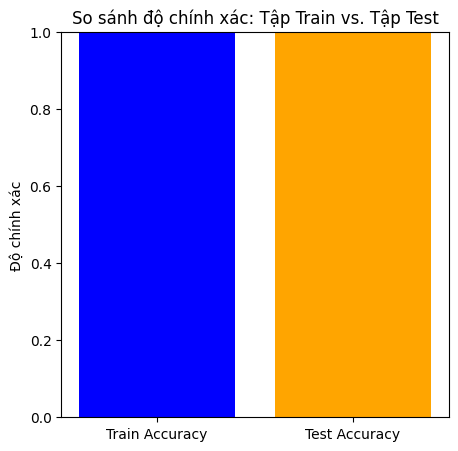

In [16]:
from sklearn.metrics import accuracy_score

# Tính độ chính xác cho tập train
train_accuracy = accuracy_score(y_train, best_svm.predict(X_train))


plt.figure(figsize=(5,5))
plt.bar(["Train Accuracy", "Test Accuracy"], [train_accuracy, acc], color=['blue', 'orange'])
plt.ylim(0, 1)
plt.ylabel("Độ chính xác")
plt.title("So sánh độ chính xác: Tập Train vs. Tập Test")
plt.show()


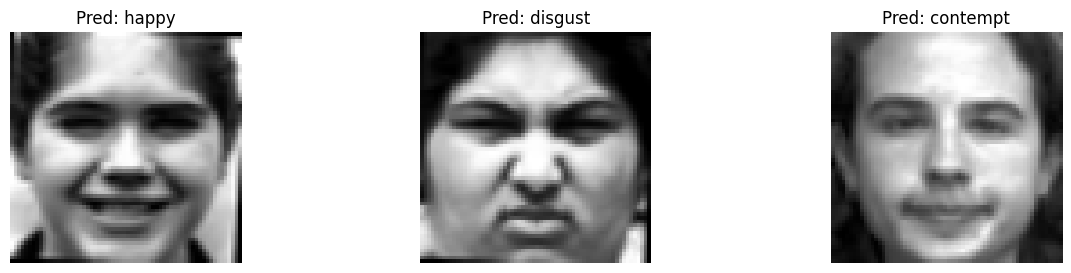

In [12]:
def predict_image(img_path, svm_model, scaler, pca):
    """
    Hàm này nhận đường dẫn đến ảnh, thực hiện tiền xử lý và trích xuất đặc trưng (HOG + DCT),
    sau đó chuẩn hóa và giảm chiều bằng scaler và PCA đã huấn luyện.
    Cuối cùng, mô hình KNN được dùng để dự đoán nhãn của ảnh.

    Parameters:
        img_path (str): Đường dẫn đến ảnh.
        knn_model (estimator): Mô hình KNN đã được huấn luyện.
        scaler (StandardScaler): Đối tượng scaler đã fit trên dữ liệu huấn luyện.
        pca (PCA): Mô hình PCA đã được fit trên dữ liệu huấn luyện.

    Returns:
        tuple: (predicted_label, processed_img)
    """
    processed_img = preprocess_image(img_path)  # Hàm preprocess_image phải được định nghĩa sẵn trong pipeline của bạn
    if processed_img is None:
        raise ValueError("Không đọc được ảnh từ đường dẫn: " + img_path)
    
    hog_feat = extract_hog_features(processed_img)
    dct_feat = extract_dct_features(processed_img, keep_coeffs=8)  # 8x8 = 64 đặc trưng
    combined = np.concatenate((hog_feat, dct_feat))
    
    # Chuẩn hóa vector đặc trưng theo scaler đã học (với input là một mảng 2 chiều)
    combined_scaled = scaler.transform([combined])
    # Giảm chiều vector đặc trưng sử dụng PCA đã học
    combined_pca = pca.transform(combined_scaled)
    predicted = svm_model.predict(combined_pca)
    return predicted[0], processed_img

test_image_paths = [
    '/kaggle/input/ck-dataset/happy/S011_006_00000011.png',
    '/kaggle/input/ck-dataset/disgust/S005_001_00000009.png',
    '/kaggle/input/ck-dataset/contempt/S151_002_00000029.png'
]

fig, axes = plt.subplots(1, len(test_image_paths), figsize=(15, 3))
for ax, img_path in zip(axes, test_image_paths):
    pred_label, img = predict_image(img_path, best_svm, scaler, pca_model)
    ax.imshow(img, cmap='gray')
    ax.set_title("Pred: " + CATEGORIES[pred_label])
    ax.axis('off')

plt.show()

## SVM Code Tay

Số thành phần được chọn: 208
Tỷ lệ phương sai giải thích: 0.9000637563180738


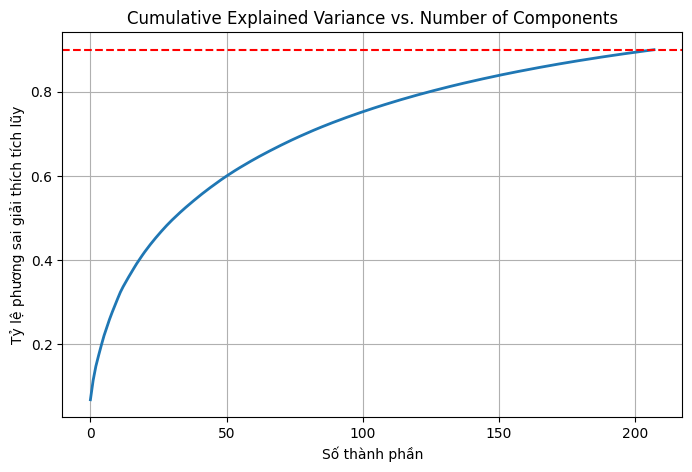

Manual SVM Accuracy: 0.9847715736040609
              precision    recall  f1-score   support

    surprise       1.00      1.00      1.00        42
        fear       1.00      1.00      1.00        21
     sadness       1.00      1.00      1.00        18
     disgust       1.00      0.92      0.96        37
    contempt       0.82      1.00      0.90        14
       happy       1.00      1.00      1.00        42
       anger       1.00      1.00      1.00        23

    accuracy                           0.98       197
   macro avg       0.97      0.99      0.98       197
weighted avg       0.99      0.98      0.99       197



In [13]:
import numpy as np
from sklearn.metrics import accuracy_score, classification_report

def reduce_dimensionality(features, variance_threshold=0.95):
    """
    Chuẩn hóa và giảm chiều vector đặc trưng bằng StandardScaler và PCA, 
    tự động giữ lại đủ số thành phần để tổng tỷ lệ phương sai giải thích đạt ngưỡng nhất định.
    
    Parameters:
        features (np.ndarray): Ma trận đặc trưng ban đầu.
        variance_threshold (float): Ngưỡng tỷ lệ phương sai giải thích (ví dụ 0.95 nghĩa là 95%).
        
    Returns:
        features_pca (np.ndarray): Ma trận đặc trưng sau PCA.
        pca (PCA object): Mô hình PCA đã fit.
    """
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(features)
    
    # Sử dụng PCA để tự động chọn số thành phần sao cho đạt ngưỡng explained variance
    pca = PCA(n_components=variance_threshold)
    features_pca = pca.fit_transform(scaled_features)
    
    print("Số thành phần được chọn:", pca.n_components_)
    print("Tỷ lệ phương sai giải thích:", np.sum(pca.explained_variance_ratio_))

    import matplotlib.pyplot as plt
    cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
    plt.figure(figsize=(8, 5))
    plt.plot(cumulative_variance, linewidth=2)
    plt.xlabel("Số thành phần")
    plt.ylabel("Tỷ lệ phương sai giải thích tích lũy")
    plt.title("Cumulative Explained Variance vs. Number of Components")
    plt.grid(True)
    plt.axhline(y=variance_threshold, color='r', linestyle='--')
    plt.show()
    return features_pca, pca, scaler


features_pca, pca_model, scaler = reduce_dimensionality(combined_features, variance_threshold=0.9)

class OneVsRestSVM:
    """
    Một cài đặt SVM tuyến tính theo phương pháp One-vs-Rest sử dụng gradient descent để tối ưu hàm mất mát hinge.
    
    Hàm mất mát (loss) của một bộ phân loại binary cho từng lớp được định nghĩa như sau:
    
        L(w, b) = (lambda_reg/2) * ||w||^2 + sum_i max(0, 1 - y_i*(w^T x_i + b))
    
    Trong đó y_i ∈ {+1, -1} được gán cho từng bộ phân lớp trong chiến lược one-vs-rest.
    """
    def __init__(self, learning_rate=0.001, n_iters=1000, lambda_reg=0.01):
        self.learning_rate = learning_rate
        self.n_iters = n_iters
        self.lambda_reg = lambda_reg
        self.classes_ = None
        self.W = {}  # Mỗi lớp sẽ có một bộ (w, b)

    def fit(self, X, y):
        """
        Huấn luyện SVM theo chiến lược One-vs-Rest.

        Parameters:
            X (np.ndarray): Ma trận đặc trưng huấn luyện, kích thước (n_samples, n_features).
            y (np.ndarray): Nhãn huấn luyện dạng số nguyên (0, 1, 2, …).
        """
        self.classes_ = np.unique(y)
        n_samples, n_features = X.shape

        for c in self.classes_:
            # Gán nhãn binary: +1 nếu mẫu thuộc lớp c, ngược lại -1.
            y_binary = np.where(y == c, 1, -1)

            # Khởi tạo weight và bias (có thể khởi tạo ngẫu nhiên; ở đây khởi tạo bằng 0)
            w = np.zeros(n_features)
            b = 0

            # Huấn luyện bằng batch gradient descent
            for _ in range(self.n_iters):
                # Tính giá trị dự đoán: f(x) = w^T x + b và margin: 1 - y * f(x)
                margins = 1 - y_binary * (np.dot(X, w) + b)
                # Xác định các mẫu vi phạm margin (max(0, margin) > 0)
                idx = margins > 0

                # Tính gradient của hàm mất mát:
                # grad_w = lambda_reg * w - sum_{i: margin>0}(y_i * x_i)
                # grad_b = - sum_{i: margin>0}(y_i)
                grad_w = self.lambda_reg * w - np.dot(X[idx].T, y_binary[idx])
                grad_b = -np.sum(y_binary[idx])

                # Cập nhật trọng số và bias
                w = w - self.learning_rate * grad_w
                b = b - self.learning_rate * grad_b

            self.W[c] = (w, b)
        return self

    def predict(self, X):
        """
        Dự đoán nhãn cho các mẫu trong X dựa trên hàm số của từng bộ phân lớp.

        Parameters:
            X (np.ndarray): Ma trận đặc trưng, kích thước (n_samples, n_features).

        Returns:
            np.ndarray: Mảng nhãn dự đoán cho mỗi mẫu.
        """
        n_samples = X.shape[0]
        scores = np.zeros((n_samples, len(self.classes_)))
        for i, c in enumerate(self.classes_):
            w, b = self.W[c]
            scores[:, i] = np.dot(X, w) + b
        # Dự đoán nhãn bằng cách chọn lớp có giá trị score lớn nhất cho mỗi mẫu
        predictions = np.argmax(scores, axis=1)
        return predictions


X_train, X_test, y_train, y_test = train_test_split(features_pca, labels, test_size=0.2, random_state=42)

# Khởi tạo và huấn luyện SVM "tay" (One-vs-Rest)
manual_svm = OneVsRestSVM(learning_rate=0.0005, n_iters=5000, lambda_reg=0.01)
manual_svm.fit(X_train, y_train)

y_pred_manual = manual_svm.predict(X_test)

acc_manual = accuracy_score(y_test, y_pred_manual)
print("Manual SVM Accuracy:", acc_manual)
print(classification_report(y_test, y_pred_manual, target_names=CATEGORIES))


In [14]:
import os
import cv2
import numpy as np
from tqdm import tqdm
from skimage.feature import hog
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt

#############################################
# Giả sử rằng phần trích xuất đặc trưng đã được thực hiện 
# và tạo ra biến `combined_features` và `labels`.
#############################################

# Ví dụ minh họa: (Bạn thay thế bằng pipeline trích xuất đặc trưng thực tế của bạn)
# combined_features: ma trận đặc trưng kết hợp từ HOG và DCT của toàn bộ ảnh (số mẫu x số chiều)
# labels: mảng nhãn (số nguyên) ứng với từng ảnh
# Ở đây, tôi giả sử các biến này đã tồn tại.

#############################################
# 1. Hàm giảm chiều dữ liệu (chuẩn hóa + PCA)
#############################################
def reduce_dimensionality(features, variance_threshold=0.95):
    """
    Chuẩn hóa và giảm chiều vector đặc trưng bằng StandardScaler và PCA,
    tự động giữ lại đủ số thành phần để tổng tỷ lệ phương sai giải thích đạt ngưỡng.
    
    Parameters:
        features (np.ndarray): Ma trận đặc trưng ban đầu.
        variance_threshold (float): Ngưỡng explained variance (ví dụ: 0.95).
        
    Returns:
        features_pca (np.ndarray): Ma trận đặc trưng sau PCA.
        pca (PCA object): Đối tượng PCA đã fit.
        scaler (StandardScaler object): Đối tượng scaler đã fit.
    """
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(features)
    
    # Áp dụng PCA theo ngưỡng explained variance
    pca = PCA(n_components=variance_threshold)
    features_pca = pca.fit_transform(scaled_features)
    
    print("Số thành phần được giữ lại:", pca.n_components_)
    print("Tỷ lệ phương sai giải thích tích lũy:", np.sum(pca.explained_variance_ratio_))
    
    cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
    plt.figure(figsize=(8, 5))
    plt.plot(np.arange(1, pca.n_components_+1), cumulative_variance, linewidth=2, marker='o')
    plt.xlabel("Số thành phần")
    plt.ylabel("Tỷ lệ phương sai giải thích tích lũy")
    plt.title("Cumulative Explained Variance vs. Number of Components")
    plt.grid(True)
    plt.axhline(y=variance_threshold, color='r', linestyle='--')
    plt.show()
    
    return features_pca, pca, scaler

# Giả sử biến combined_features đã được tính
# features_pca, pca_model, scaler = reduce_dimensionality(combined_features, variance_threshold=0.9)
# Nếu muốn dùng số nguyên cố định thay vì threshold, có thể thiết lập PCA(n_components=32).

#############################################
# 2. Cài đặt SVM tay theo chiến lược One-vs-Rest với mini-batch và momentum
#############################################
class OneVsRestSVM:
    """
    Cài đặt SVM tuyến tính theo phương pháp One-vs-Rest sử dụng mini-batch gradient descent
    kết hợp momentum để tối ưu hóa hàm mất mát hinge.
    
    Hàm mất mát cho bộ phân lớp binary cho mỗi lớp:
        L(w, b) = (lambda_reg / 2) * ||w||^2 + sum_i max(0, 1 - y_i*(w^T x_i + b))
    với y_i ∈ {+1, -1}.
    """
    def __init__(self, learning_rate=0.001, n_iters=1000, lambda_reg=0.01, batch_size=None, momentum=0.9):
        self.learning_rate = learning_rate
        self.n_iters = n_iters
        self.lambda_reg = lambda_reg
        self.batch_size = batch_size  # nếu None, sử dụng toàn bộ tập dữ liệu (batch gradient descent)
        self.momentum = momentum
        self.classes_ = None
        self.W = {}  # Dictionary lưu (w, b) cho từng lớp

    def fit(self, X, y):
        """
        Huấn luyện mô hình SVM theo chiến lược One-vs-Rest.
        
        Parameters:
            X (np.ndarray): Ma trận đặc trưng huấn luyện, kích thước (n_samples, n_features).
            y (np.ndarray): Nhãn huấn luyện dạng số nguyên.
        """
        self.classes_ = np.unique(y)
        n_samples, n_features = X.shape
        
        # Nếu batch_size không được chỉ định, sử dụng toàn bộ dữ liệu
        if self.batch_size is None:
            self.batch_size = n_samples
        
        for c in self.classes_:
            # Tạo nhãn binary cho lớp c: +1 nếu mẫu thuộc lớp c, -1 nếu không.
            y_binary = np.where(y == c, 1, -1)
            w = np.zeros(n_features)
            b = 0
            # Khởi tạo các biến momentum cho trọng số và bias
            v_w = np.zeros(n_features)
            v_b = 0
            
            for _ in range(self.n_iters):
                # Lấy ngẫu nhiên một mini-batch
                indices = np.random.choice(n_samples, self.batch_size, replace=False)
                X_batch = X[indices]
                y_batch = y_binary[indices]
                
                # Tính margin: 1 - y * (w^T x + b)
                margins = 1 - y_batch * (np.dot(X_batch, w) + b)
                # Chỉ lấy các mẫu có margin > 0 (tức vi phạm điều kiện SVM)
                idx = margins > 0
                
                if np.any(idx):
                    grad_w = self.lambda_reg * w - np.dot(X_batch[idx].T, y_batch[idx])
                    grad_b = -np.sum(y_batch[idx])
                else:
                    grad_w = self.lambda_reg * w
                    grad_b = 0
                
                # Cập nhật momentum: v = momentum * v - learning_rate * grad
                v_w = self.momentum * v_w - self.learning_rate * grad_w
                v_b = self.momentum * v_b - self.learning_rate * grad_b
                
                # Cập nhật tham số
                w = w + v_w
                b = b + v_b
            
            self.W[c] = (w, b)
        return self

    def predict(self, X):
        """
        Dự đoán nhãn cho các mẫu trong X bằng cách tính điểm của từng bộ phân lớp.
        
        Parameters:
            X (np.ndarray): Ma trận đặc trưng, kích thước (n_samples, n_features).
            
        Returns:
            np.ndarray: Mảng nhãn dự đoán.
        """
        n_samples = X.shape[0]
        scores = np.zeros((n_samples, len(self.classes_)))
        for i, c in enumerate(self.classes_):
            w, b = self.W[c]
            scores[:, i] = np.dot(X, w) + b
        predictions = np.argmax(scores, axis=1)
        return predictions

#############################################
# 3. Chia dữ liệu và huấn luyện mô hình SVM tay
#############################################
# Giả sử features_pca và labels đã có (sau bước giảm chiều bằng PCA)
X_train, X_test, y_train, y_test = train_test_split(features_pca, labels, test_size=0.2, random_state=42)

# Khởi tạo SVM tay với mini-batch gradient descent và momentum.
# Bạn có thể thử nghiệm với batch_size (ví dụ 32) hoặc để None để dùng toàn bộ tập dữ liệu.
manual_svm = OneVsRestSVM(learning_rate=0.0005, n_iters=5000, lambda_reg=0.01, batch_size=32, momentum=0.9)
manual_svm.fit(X_train, y_train)

y_pred_manual = manual_svm.predict(X_test)
acc_manual = accuracy_score(y_test, y_pred_manual)
print("Manual SVM Accuracy:", acc_manual)
print(classification_report(y_test, y_pred_manual, target_names=CATEGORIES))



Manual SVM Accuracy: 1.0
              precision    recall  f1-score   support

    surprise       1.00      1.00      1.00        42
        fear       1.00      1.00      1.00        21
     sadness       1.00      1.00      1.00        18
     disgust       1.00      1.00      1.00        37
    contempt       1.00      1.00      1.00        14
       happy       1.00      1.00      1.00        42
       anger       1.00      1.00      1.00        23

    accuracy                           1.00       197
   macro avg       1.00      1.00      1.00       197
weighted avg       1.00      1.00      1.00       197



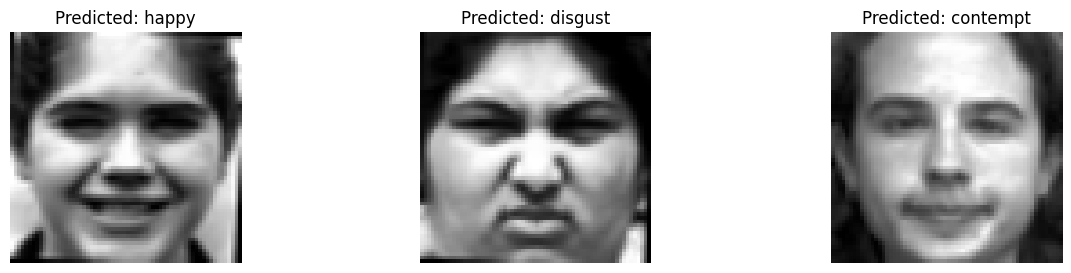

In [15]:

def predict_image(img_path, svm_model, scaler, pca):
    """
    Dự đoán nhãn cho ảnh mới:
      - Tiền xử lý ảnh.
      - Trích xuất đặc trưng HOG và DCT, sau đó kết hợp chúng.
      - Chuẩn hóa và giảm chiều bằng scaler và pca đã học.
      - Dự đoán nhãn bằng mô hình SVM tay.
      
    Parameters:
        img_path (str): Đường dẫn ảnh.
        svm_model (OneVsRestSVM): Mô hình SVM tay đã huấn luyện.
        scaler (StandardScaler): Đối tượng scaler đã fit.
        pca (PCA): Mô hình PCA đã fit.
        
    Returns:
        tuple: (predicted_label, processed_img)
    """
    proc_img = preprocess_image(img_path)
    if proc_img is None:
        raise ValueError("Không đọc được ảnh từ: " + img_path)
    
    hog_feat = extract_hog_features(proc_img)
    dct_feat = extract_dct_features(proc_img, keep_coeffs=8)
    combined = np.concatenate((hog_feat, dct_feat))
    
    combined_scaled = scaler.transform([combined])
    combined_pca = pca.transform(combined_scaled)
    
    pred = svm_model.predict(combined_pca)
    return pred[0], proc_img

# Danh sách đường dẫn ảnh mới để dự đoán
test_image_paths = [
    '/kaggle/input/ck-dataset/happy/S011_006_00000011.png',
    '/kaggle/input/ck-dataset/disgust/S005_001_00000009.png',
    '/kaggle/input/ck-dataset/contempt/S151_002_00000029.png'
]

fig, axes = plt.subplots(1, len(test_image_paths), figsize=(15, 3))
for ax, path in zip(axes, test_image_paths):
    pred_label, img = predict_image(path, manual_svm, scaler, pca_model)
    ax.imshow(img, cmap='gray')
    ax.set_title("Predicted: " + CATEGORIES[pred_label])
    ax.axis('off')
plt.show()
